[Reference](https://medium.com/m2mtechconnect/detecting-headline-sarcasm-with-machine-learning-4c3523104cdf)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [2]:
df = pd.read_json(r'https://raw.githubusercontent.com/Branden-Kang/Natural-Language-Processing/master/Data/Sarcasm_Headlines_Dataset.json', lines=True)
df = df.drop(['article_link'], axis=1)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
# first 5 headlines
for i in range(0, 5):
    print(df.iloc[i]['headline'], '\n')

former versace store clerk sues over secret 'black code' for minority shoppers 

the 'roseanne' revival catches up to our thorny political mood, for better and worse 

mom starting to fear son's web series closest thing she will have to grandchild 

boehner just wants wife to listen, not come up with alternative debt-reduction ideas 

j.k. rowling wishes snape happy birthday in the most magical way 



# Exploratory Data Analysis


In [4]:
# check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      26709 non-null  object
 1   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 417.5+ KB


In [5]:
# check that there are only 2 labels 
df['is_sarcastic'].unique()

array([0, 1])

In [6]:
# group df by class for further analysis
groups = df.groupby('is_sarcastic')

In [7]:
groups.get_group(0)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
4,j.k. rowling wishes snape happy birthday in th...,0
5,advancing the world's women,0
6,the fascinating case for eating lab-grown meat,0
...,...,...
26704,american politics in moral free-fall,0
26705,america's best 20 hikes,0
26706,reparations and obama,0
26707,israeli ban targeting boycott supporters raise...,0


In [8]:
# number of samples per class
num_sarcastic = len(groups.get_group(1))
num_nonsarcastic = len(groups.get_group(0))
print("Number of sarcastic samples: ", num_sarcastic)
print("Number of nonsarcastic samples: ", num_nonsarcastic)

Number of sarcastic samples:  11724
Number of nonsarcastic samples:  14985


In [9]:
def get_median_num_words(df):
    """Returns the median number of words in headline per row given dataframe

    # Arguments
        df: dataframe, contains headlines and their labels
    
    # Returns
        int, median number of words per headline
    """
    num_words = [len(s.split()) for s in df.headline]
    return np.median(num_words)

# median number of words per sample
num_words_sarcastic = get_median_num_words(groups.get_group(1))
num_words_nonsarcastic = get_median_num_words(groups.get_group(0))
print("Median number of words in sarcastic samples: ", num_words_sarcastic)
print("Median number of words in nonsarcastic samples: ", num_words_nonsarcastic)

Median number of words in sarcastic samples:  10.0
Median number of words in nonsarcastic samples:  10.0


In [10]:
def plot_sample_length_distribution(df):
    """Plots the headline length distribution

    # Arguments
        df: dataframe, contains headlines and their labels
    """
    plt.hist([len(s) for s in df.headline], bins=50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

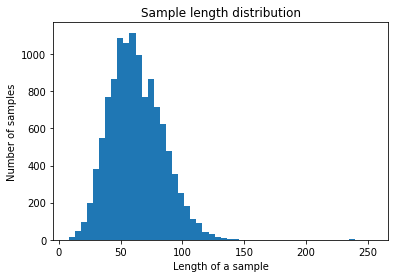

In [11]:
# plot length distribution of sarcastic headlines
plot_sample_length_distribution(groups.get_group(1))

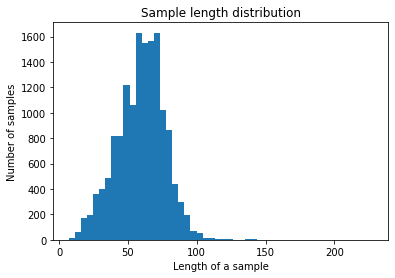

In [12]:
# plot length distribution of nonsarcastic headlines
plot_sample_length_distribution(groups.get_group(0))

In [13]:
def plot_frequency_distribution_of_ngrams(headlines,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.
    # Arguments
        headlines: pandas series, headlines.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(headlines)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(20,5))
    plt.rcParams.update({'font.size': 15})
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()

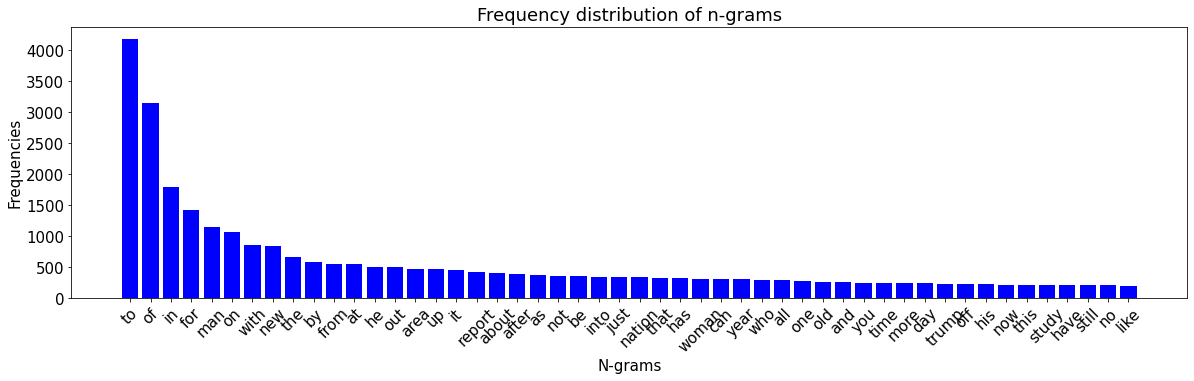

In [14]:

# plot ngram freq distribution of sarcastic headlines
plot_frequency_distribution_of_ngrams(groups.get_group(1).headline)

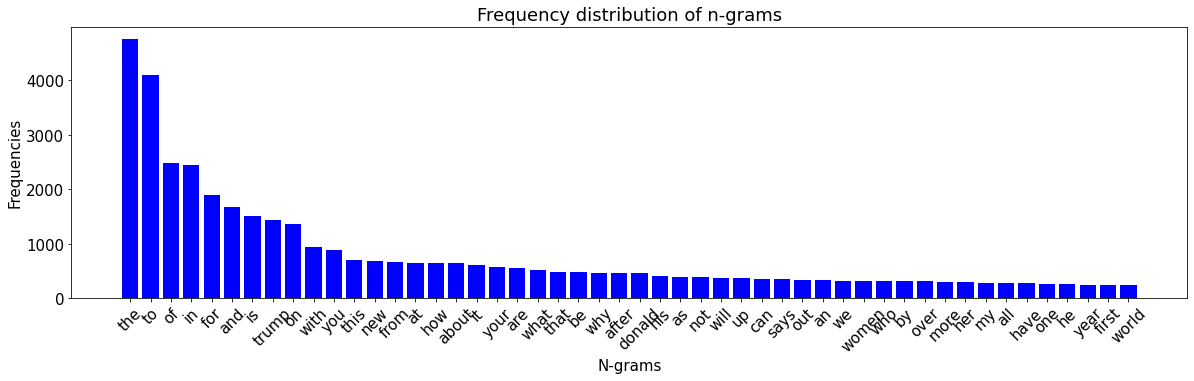

In [15]:
# plot ngram freq distribution of nonsarcastic headlines
plot_frequency_distribution_of_ngrams(groups.get_group(0).headline)

# Data Preprocessing


In [16]:
# number of samples/number of words per sample ratio
print('Number of samples/number of words per sample ratio in sarcastic samples: ', 
      num_sarcastic/num_words_sarcastic)
print('Number of samples/number of words per sample ratio in nonsarcastic samples: ', 
      num_nonsarcastic/num_words_nonsarcastic)

Number of samples/number of words per sample ratio in sarcastic samples:  1172.4
Number of samples/number of words per sample ratio in nonsarcastic samples:  1498.5


In [17]:
X = np.array(df.headline)
y = np.array(df.is_sarcastic)
train_texts, val_texts, train_labels, val_labels = train_test_split(X, y, test_size=0.2, random_state=8)

In [18]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [19]:
x_train, x_val = ngram_vectorize(train_texts, train_labels, val_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1817: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


# Training the Model


## Linear Support Vector Classification

In [20]:
from sklearn import svm

clf = svm.LinearSVC()
clf.fit(x_train, train_labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [21]:
from sklearn.metrics import accuracy_score

val_pred = clf.predict(x_val)
print('Accuracy:', accuracy_score(val_labels, val_pred))

Accuracy: 0.8584799700486709


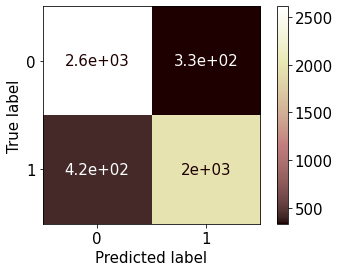

In [22]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, x_val, val_labels, cmap='pink')  
plt.show()

## Complement Naive Bayes

In [23]:
from sklearn.naive_bayes import ComplementNB

clf = ComplementNB()
clf.fit(x_train, train_labels)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

Accuracy: 0.8532384874578809


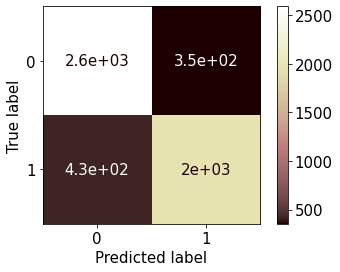

In [24]:
val_pred = clf.predict(x_val)
print('Accuracy:', accuracy_score(val_labels, val_pred))
plot_confusion_matrix(clf, x_val, val_labels, cmap='pink')  
plt.show()

# Multilayer Perceptron

In [25]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [26]:
model = models.Sequential([
    layers.Dense(units=32, activation='relu', 
                 kernel_regularizer=regularizers.l2(0.001), 
                 input_shape=x_train.shape[1:]),
    layers.Dropout(rate=0.5),
    layers.Dense(units=32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(rate=0.5),
    layers.Dense(units=1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                640032    
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 641,121
Trainable params: 641,121
Non-trainable params: 0
_________________________________________________________________


In [27]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [28]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)]

history = model.fit(
    x_train,
    train_labels,
    epochs=100,
    callbacks=callbacks,
    validation_data=(x_val, val_labels),
    verbose=2,
    batch_size=512
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


42/42 - 2s - loss: 0.7174 - acc: 0.5635 - val_loss: 0.6850 - val_acc: 0.5520
Epoch 2/100
42/42 - 1s - loss: 0.6519 - acc: 0.6598 - val_loss: 0.6142 - val_acc: 0.7265
Epoch 3/100
42/42 - 1s - loss: 0.5733 - acc: 0.8039 - val_loss: 0.5382 - val_acc: 0.8330
Epoch 4/100
42/42 - 1s - loss: 0.5034 - acc: 0.8605 - val_loss: 0.4945 - val_acc: 0.8523
Epoch 5/100
42/42 - 1s - loss: 0.4596 - acc: 0.8823 - val_loss: 0.4769 - val_acc: 0.8570
Epoch 6/100
42/42 - 1s - loss: 0.4289 - acc: 0.8980 - val_loss: 0.4713 - val_acc: 0.8587
Epoch 7/100
42/42 - 1s - loss: 0.4052 - acc: 0.9110 - val_loss: 0.4699 - val_acc: 0.8581
Epoch 8/100
42/42 - 1s - loss: 0.3944 - acc: 0.9177 - val_loss: 0.4772 - val_acc: 0.8579


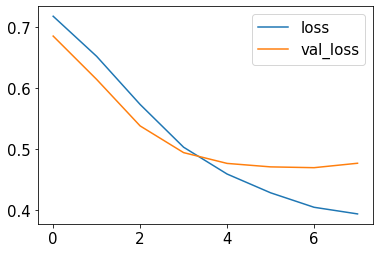

In [29]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

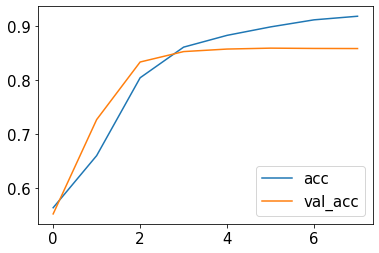

In [30]:
metrics = history.history
plt.plot(history.epoch, metrics['acc'], metrics['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()

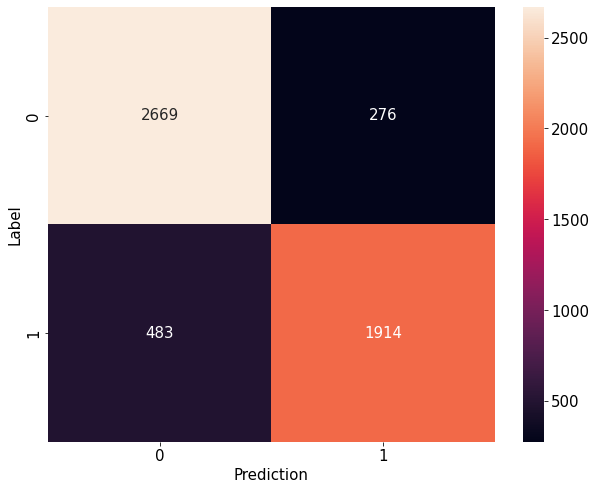

In [31]:
# get model predictions for validation set
val_pred = model.predict(x_val)
val_pred = [1 if n >= 0.5 else 0 for n in val_pred]

# confusion matrix for validation predictions
confusion_mtx = tf.math.confusion_matrix(val_labels, val_pred, num_classes=2) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()